In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

from epsilon_transformers.process.processes import RRXOR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialize the RRXOR process
This library has a Process class that we use to define a data generating HMM.

The most important part of the process is the transition matrix, which defines the transitions between states. You can get it via `process.transition_matrix`. It is a numpy array of shape (num_emission, num_states, num_states), and defines the transition probabilities from state i to state j given emission k.

The process also has a `state_names_dict`, which is a dictionary mapping state names to state indices. You can get it via `process.state_names_dict`.


In [23]:
process = RRXOR()
print(process)

rrxor Process
Number of states: 5
Vocabulary length: 2
Transition matrix shape: (2, 5, 5)


In [24]:
process.transition_matrix

array([[[0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5],
        [0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [1. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0.5],
        [1. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ]]])

In [25]:
process.state_names_dict

{'S': 0, '0': 1, '1': 2, 'T': 3, 'F': 4}

# Visualizing the process

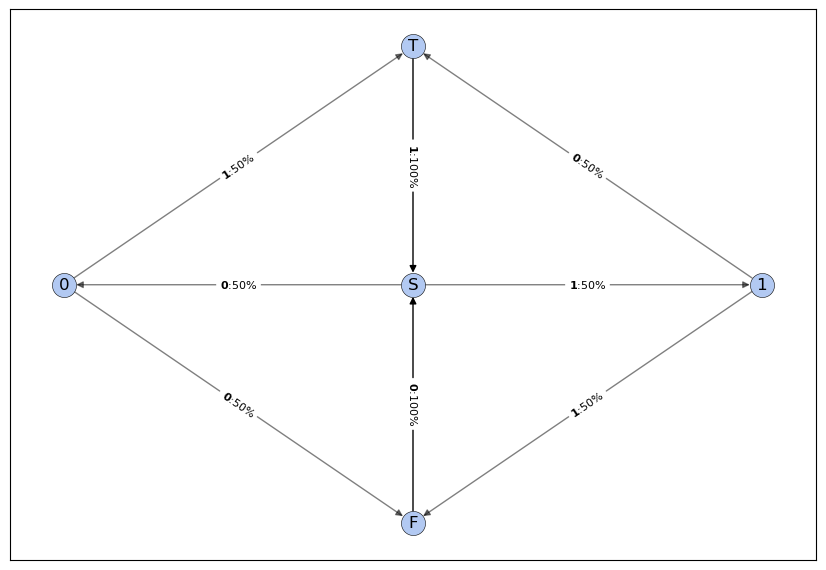

In [26]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph

graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

# Computing the Mixed-State Presentation

The computation of the MSP from the process is in two steps:
1. Compute a tree of that keeps track of belief states as nodes, and emissions as edges. This is called a `MixedStateTree` and you can get it via `process.derive_mixed_state_presentation(depth=N)`, where N is the maximum length of sequences you want to consider.
2. Once we have a tree, we can then compute the MSP via `msp_tree.build_transition_graph()`. This returns a transition matrix which we can then use to create another `Process` using the `TransitionMatrixProcess` class.

We go through these steps and then visualize the MSP.

In [27]:
mixed_state_tree = process.derive_mixed_state_presentation(depth=11)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

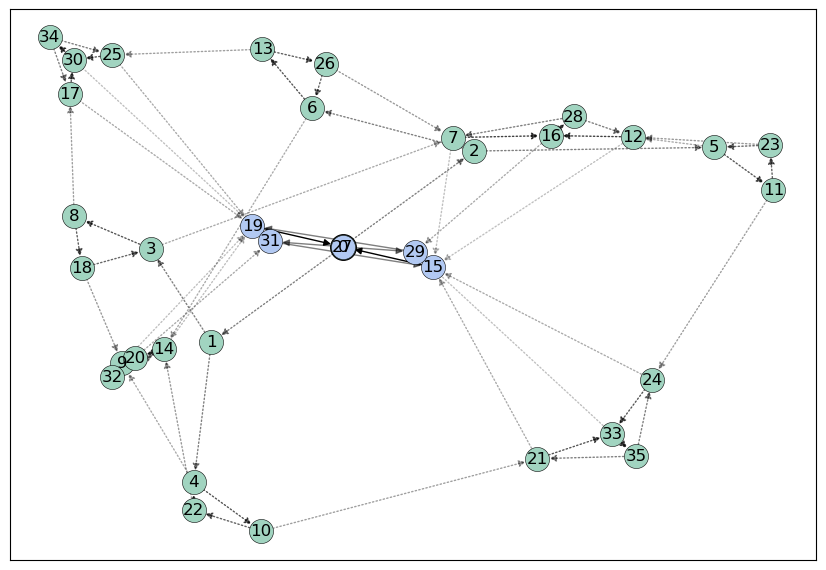

In [28]:
# make a process out of the transition matrix
from epsilon_transformers.process.processes import TransitionMatrixProcess
process = TransitionMatrixProcess(transition_matrix=MSP_transition_matrix)
graph = transition_matrix_to_graph(transition_matrix=MSP_transition_matrix)
visualize_graph(graph, draw_mixed_state=True, layout='spectral', draw_edge_labels=False, draw_color=False)


# The myopic entropy rate

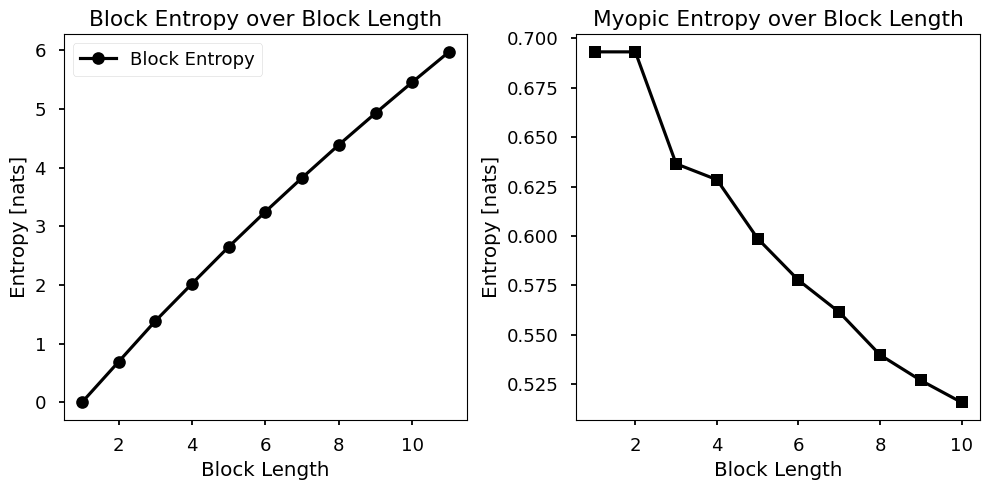

In [29]:
# compute the myopic entropy rate from the msp
block_entropy = mixed_state_tree.block_entropy
myopic_entropy = mixed_state_tree.myopic_entropy

# use seaborn to plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-talk')
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting Block Entropy
axs[0].plot(np.arange(1, len(block_entropy) + 1), block_entropy, label='Block Entropy', color='black', marker='o', linestyle='-')
axs[0].set_title('Block Entropy over Block Length')
axs[0].set_xlabel('Block Length')
axs[0].set_ylabel('Entropy [nats]')
axs[0].legend()

# Plotting Myopic Entropy
axs[1].plot(np.arange(1, len(myopic_entropy) + 1), myopic_entropy, label='Myopic Entropy', color='black', marker='s', linestyle='-')
axs[1].set_title('Myopic Entropy over Block Length')
axs[1].set_xlabel('Block Length')
axs[1].set_ylabel('Entropy [nats]')
plt.tight_layout()
plt.show()



# Simplex Analysis

## Ground Truth Simplex

To get the ground truth simplex structure, we need to get all paths of any length on the mixed state tree, and their associated belief states. To do this, we use `mixed_state_tree.paths_and_belief_states`, which returns a list of tuples, where the first element is the path, and the second element is the belief state associated with it.



In [30]:
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

Path: 01100000111, Belief: [0. 0. 1. 0. 0.]
Path: 011000001, Belief: [0. 0. 0. 1. 0.]
Path: 01100000011, Belief: [0. 0. 0. 0. 1.]
Path: 01011100001, Belief: [0. 0. 1. 0. 0.]
Path: 01011100111, Belief: [0. 0. 1. 0. 0.]


In [31]:
# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

Number of Unique beliefs: 36 out of 1723


In [32]:
# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

(0.5, 0.25, 0.0, 0.0, 0.25) is indexed as 0
(0.33333, 0.0, 0.33333, 0.16667, 0.16667) is indexed as 1
(0.0, 0.0, 1.0, 0.0, 0.0) is indexed as 2
(0.0, 0.0, 0.5, 0.5, 0.0) is indexed as 3
(0.0, 0.66667, 0.0, 0.0, 0.33333) is indexed as 4


Because the ground truth simplex is a 4 dimensional object, we need to project down to 3D somehow. We will use PCA

In [33]:
def run_visualization_pca(beliefs):
    pca = PCA(n_components=3)
    pca.fit(beliefs)

    return pca


def visualize_ground_truth_simplex_3d(beliefs, belief_labels, pca):

    beliefs_pca = pca.transform(beliefs)

    colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly
    fig = px.scatter_3d(beliefs_pca, x=0, y=1, z=2,
                        color=[str(i) for i in belief_labels],
                        color_discrete_sequence=colors)
    fig.show()

vis_pca = run_visualization_pca(list(msp_belief_index.keys()))
index = list(msp_belief_index.values())
visualize_ground_truth_simplex_3d(list(msp_belief_index.keys()),
                                  list(msp_belief_index.values()),
                                  vis_pca)


We can also look at it in 2D, which is fun because it looks like some kind of crystalography experiment.

In [34]:
beliefs_3d = vis_pca.transform(list(msp_belief_index.keys()))

# make a 2d plot using the 0th and 1st dim of beliefs_3d
fig = px.scatter(beliefs_3d, x=0, y=2, 
                 color=[str(i) for i in list(msp_belief_index.values())],
                 title='2D Plot of MSP Beliefs',
                 labels={'x': 'PCA Dimension 1', 'y': 'PCA Dimension 2', 'color': 'Belief State'},
                 color_continuous_scale=px.colors.qualitative.Light24,
                 size_max=20)  # Increase the size of the dots

# Make the figure square
fig.update_layout(width=400, height=400)

fig.show()


(36, 3)